# Coursera Capstone Project
### By Hardeep Dhaliwal


## Best Neighborhood for a NightClub in Amsterdam

### Introduction
This project aids to find the optimal location for a NightClub in Amsterdam to aid with tourism and generating traffic into Amsterdam as covid-19 restrictions loosen around the world. Through the usage of python, foursquare API, libraries, and data visualization techniques an optimal neighborhood location in Amsterdam will be selected. 

### Background Discussion
As the vaccine rollout accelerates around the world and more countries are opening borders and allowing tourists to visit the nightlife scene will only grow and have the potential to generate large amounts of revenue for businesses looking to take advantage. In choosing the city for this new NightClub, Amsterdam was selected based on its history of being one of the greatest cities in the world to party in. According to [Thrillophilia]( https://www.thrillophilia.com/blog/greatest-cities-in-the-world-to-party/) Amsterdam is ranked 3rd in the world for cities to party in, making it an excellent city to host this new NightClub. In addition to reputation, looking at the data of inbound tourists in the netherlands, according to [statista]( https://www.statista.com/statistics/658819/inbound-tourism-forecast-in-the-netherlands/) the amount of tourists coming into the Netherlands from 2014 to 2019 was steadily increasing and peaked at **20.1 million** in 2019. The value dropped with the restrictions caused from the covid-19 pandemic to 7 million, however, as vaccines get distributed and restrictions are lifted, this value will rebound and create demand for tourist attractions like a NightClub.

Now, with the problem and background defined, the data and parameters that are going to be used for picking the neighborhood to host this nightclub must be defined as well.

According to [superevent]( https://superevent.com/blog/13-important-things-to-consider-when-choosing-your-event-venue/) important factors to consider when choosing an event venue include, parking and accessiblity. Therefore, the location must have large enough parking spots within a given radius and be easily accessbile by as many modes of transportation, including public transport like buses, metro/subway stations, train stations, etc. 

### Description of the Data
First and foremost, to select the optimal neighborhood that would host this new NightClub, data about the different neighborhoods in Amsterdam is required. To achieve this, the website [ClairCity]( https://claircitydata.cbs.nl/dataset/districts-and-neighbourhoods-amsterdam) provides a dataset on the districts and neighborhoods in Amsterdam. Next, the parking lots location in Amsterdam can be found via the [FourSquare API]( https://developer.foursquare.com/docs/build-with-foursquare/categories/). The final dataset we need can also be found via the FourSquare API and it includes the public transportation list, which includes Bus, Metro, Light Rail, and Train stations and their respective geolocations.
With these datasets the locations of all neighborhoods and be established and clustering techniques can be used to find the optimal location which has many parking spots and is accessbile by a variety of public transportation options. 

### Data Processing and Analysis
**First, import all the necessary libraries required for data analysis and visualization**

In [62]:
import numpy as np
import pandas as pd
import json
import requests
import folium
from statistics import mean
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim #for converting adress into latitude and longitude coordinates
from pandas.io.json import json_normalize #transforming JSON files directly into pandas dataframe
from geopy.distance import geodesic
pd.options.mode.chained_assignment = None
print('Required libraries imported.')

Required libraries imported.


**Next, the ClairCity dataset is imported and stored in a pandas dataframe variable**

In [157]:
file = "https://claircitydata.cbs.nl/dataset/689ded75-1a80-4259-b033-63913573c13a/resource/d02c5f12-1cfa-4d7c-91d3-41af8e4ed634/download/wijken_buurten.csv"
df_amst_data=pd.read_csv(file,delimiter=',')
df_amst_data.shape

(579, 37)

**With many columns lets refine the dataset to only the columns which we are interested in, to do this lets look at the dataset**

In [158]:
list(df_amst_data.columns) 

['subject',
 'region_name',
 'regio_type',
 'region_code',
 'ninhabitants',
 'nmen',
 'nwomen',
 'nage_0_to_15',
 'nage_15_to_25',
 'nage_25_to_45',
 'nage_45_to_65',
 'nage_65_older',
 'nunmarried',
 'nmarried',
 'ndivorced',
 'nwidowed',
 'nimmigrant_western',
 'nimmigrant_nonwestern',
 'nimmigrant_marokko',
 'nimmigrant_antiles_aruba',
 'nimmigrant_surinam',
 'nimmigrant_turkey',
 'nimmigrant_other_non_western',
 'nhouseholds',
 'nhh_single_person',
 'nhh_no_children',
 'nhh_with_children',
 'ave_househ_size',
 'populatio_density',
 'area_total',
 'area_land',
 'area_water',
 'urbanisation_grade',
 'address_density',
 'geojson',
 'lon',
 'lat']

**The column 'regio_type' seems like it lists the different types of regions in this dataframe, lets isolate this and see what different value types it stores**

In [159]:
df_amst_data['regio_type'].value_counts()

Buurt       479
Wijk         99
Gemeente      1
Name: regio_type, dtype: int64

**Translating the above values to english,**
 - Gementee translates to a municipality 
 - Within a Gementee are several districts (Wijken)
 - The Wijken consist of several neighborhoods (Buurt)
 
**Therefore, Buurt (Neighborhoods) is the column we're interested in, so lets remove any rows with the other two values, leaving only Buurt in the regio_type column**

In [160]:
df_amst_data = df_amst_data[df_amst_data['regio_type'] == 'Buurt']
df_amst_data.shape

(479, 37)

**Now, lets isolate the columns, we only require:**
- 'subject', for the neighborhood name
- 'region_name' to ensure we are in amsterdam
- 'lon' and 'lat' for coordinate values

In [161]:
df_amst_data = df_amst_data[['subject','region_name','lon','lat']]
df_amst_data.head().reset_index(drop=True)

,subject,region_name,lon,lat
0,Kop Zeedijk,Amsterdam,4.900280,52.375937
1,Oude Kerk e.o.,Amsterdam,4.896156,52.373793
2,Burgwallen Oost,Amsterdam,4.898757,52.372815
3,Nes e.o.,Amsterdam,4.893728,52.370861
4,BG-terrein e.o.,Amsterdam,4.895584,52.369546


**The dataframe is almost complete and ready for analysis. Since we are going to be analysing the car parks and public transport stops in the neighborhood as well, lets add columns to the dataset so that later we can easily import values from FourSquare into the dataframe.**

**Also, lets rename the column headers to something that is more descriptive**

In [163]:
df_amst_data.rename(columns={'subject': 'Neighborhood', 'region_name':'City','lon':'Longitude', 'lat':'Latitude'},inplace=True)
df_amst_data['CarPark_dis'] = 0
df_amst_data['PubTrans_dis'] = 0
df_amst = df_amst_data[['Neighborhood', 'City', 'Latitude','Longitude','CarPark_dis','PubTrans_dis']].reset_index(drop=True)
df_amst.head()

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,0,0
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,0,0
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,0,0
3,Nes e.o.,Amsterdam,52.370861,4.893728,0,0
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,0,0


**To plot the map of amsterdam, we must obtain the coordinates for the map to center itself about. To achieve this just average all the values in the Longitude and Latitude columns**

In [164]:
address = 'Amsterdam'
geolocator = Nominatim(user_agent="myapplication")
location = geolocator.geocode(address)
amst_lat = location.latitude
amst_long = location.longitude
print(f'The geograpical coordinate of Amsterdam is: {amst_lat}, {amst_lon}')

The geograpical coordinate of Amsterdam is: 52.3727598, 4.895531105274008


In [165]:
# create map
map_amsterdam = folium.Map(location=[amst_lat, amst_lon], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_amst['Latitude'], df_amst['Longitude'], df_amst['City'], df_amst['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

**Now, the datasets for the parking lots and public transport locations can be imported into the dataframe.**
**To achieve this, the FourSquare API must be utilized**

In [166]:
CLIENT_ID = 'H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP' # Foursquare ID
CLIENT_SECRET = 'SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K'  # Foursquare Secret
VERSION = '20180604'
LIMIT = 100 #response limit
print('Foursquare Credentails is:\nCLIENT ID\t:',CLIENT_ID,'\nCLIENT SECRET\t:',CLIENT_SECRET)

Foursquare Credentails is:
CLIENT ID	: H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP 
CLIENT SECRET	: SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K


**The parking lots location can be found by using the categoryID of the different categories which can be found on the FourSquare webiste.**
**For Parking lots, the id is given as, 4c38df4de52ce0d596b336e1 [FourSquare](https://foursquare.com/developers/apps/H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP/settings )**

**Establishing the radius as an arbitrary value, lets print the resulting url from which we can obtain the required information**

In [167]:
# some defination
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
categoryId='4c38df4de52ce0d596b336e1' #categoryId of Parking

#create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    amst_lat, 
    amst_lon, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP&client_secret=SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K&v=20180604&ll=52.3727598,4.895531105274008&radius=3000&categoryId=4c38df4de52ce0d596b336e1&limit=100'

**From the url, lets obtain the results by sending a get request to the API**

In [168]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60c7ebb8234a3337ad3a5637'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Amsterdam',
  'headerFullLocation': 'Amsterdam',
  'headerLocationGranularity': 'city',
  'query': 'parking',
  'totalResults': 105,
  'suggestedBounds': {'ne': {'lat': 52.399759827000025,
    'lng': 4.939673044189363},
   'sw': {'lat': 52.34575977299997, 'lng': 4.851389166358653}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b531b3ef964a520208f27e3',
       'name': 'Q-Park De Bijenkorf',
       'location': {'address': 'Beursstraat 15',
        'lat': 52.37413161763709,
        'lng': 4.8945793955019345,
        'labeledLatLngs': [{'label': 'display',
          'lat

**Since we received a large dictionary, lets clean up this data into the required information we need for parking lot locations. To begin this process, lets extract the parking lots location from the results**

In [169]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Lets filter the columns so only the necessary information from the data set is extracted into the final parking lots location dataframe**

In [170]:
parking = results['response']['groups'][0]['items']

df_park = json_normalize(parking) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_park =df_park.loc[:, filtered_columns]


    
# filter the category for each row
df_park['venue.categories'] = df_park.apply(get_category_type, axis=1)


# clean columns
df_park.columns = [col.split(".")[-1] for col in df_park.columns]

df_park.head()

<ipython-input-170-48a808d73116>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_park = json_normalize(parking) # flatten JSON


,name,categories,lat,lng
0,Q-Park De Bijenkorf,Parking,52.374132,4.894579
1,MobyPark - Parking Dam Square - Book now and p...,Parking,52.373077,4.895563
2,Parkeergarage Geelvinck,Parking,52.366379,4.891984
3,Q-Park De Kolk,Parking,52.376267,4.894437
4,ParkBee,Parking,52.371025,4.895206


In [171]:
print('{} parking lots were found.'.format(df_park.shape[0]))

100 parking lots were found.


**Now that the parking lots location dataframe has been established, lets repeat this process for the public transportation spots.**

**Looking at the [FourSquare](https://developer.foursquare.com/docs/build-with-foursquare/categories/ ) site, the category ID's for the different public transportation options can be found.**
- Light Rail Station categoryId is "4bf58dd8d48988d1fc931735"
- Metro Station categoryId is "4bf58dd8d48988d1fd931735"
- Tram Station categoryId is "52f2ab2ebcbc57f1066b8b51"
- Bus Station categoryId is "4bf58dd8d48988d1fe931735"

**Lets add the different categoryID's to a list**

In [172]:
category_list=['4bf58dd8d48988d1fc931735','4bf58dd8d48988d1fd931735','52f2ab2ebcbc57f1066b8b51','4bf58dd8d48988d1fe931735']

**Since we are limited to the amount of responses we can receive from the FourSquare API, a for loop can be used to send the 4 different categoryID's as sub-categoryID's. This for loop updates the information into a dataframe called df_trans and at the end we append each iteration to the final dataframe called df_trans_total.**

In [174]:
i = 0
df_trans_tot=pd.DataFrame()
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000

for i in range(len(category_list)):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    amst_lat, 
    amst_lon, 
    radius,
    category_list[i],
    LIMIT)
    print(url) #check the URLs
    
    #Send the GET request and examine the resutls    
    results = requests.get(url).json()  
    transportation = results['response']['groups'][0]['items']
    df_trans = json_normalize(transportation) # flatten JSON  
   
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    
# Now we are ready to clean the json data and structure it into a pandas dataframe as df_trans
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    df_trans =df_trans.loc[:, filtered_columns]
    
    # filter the category for each row
    df_trans['venue.categories'] = df_trans.apply(get_category_type, axis=1)
    
    # clean columns
    df_trans.columns = [col.split(".")[-1] for col in df_trans.columns]

    print('For Category ID {} : {}'.format(category_list[i], df_trans.shape))
    
    # Update the dataframe
    df_trans_tot=df_trans_tot.append(df_trans).reset_index(drop=True)

https://api.foursquare.com/v2/venues/explore?&client_id=H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP&client_secret=SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K&v=20180604&ll=52.3727598,4.895531105274008&radius=3000&categoryId=4bf58dd8d48988d1fc931735&limit=100


<ipython-input-174-5de26fa01985>:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_trans = json_normalize(transportation) # flatten JSON


For Category ID 4bf58dd8d48988d1fc931735 : (1, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP&client_secret=SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K&v=20180604&ll=52.3727598,4.895531105274008&radius=3000&categoryId=4bf58dd8d48988d1fd931735&limit=100
For Category ID 4bf58dd8d48988d1fd931735 : (15, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP&client_secret=SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K&v=20180604&ll=52.3727598,4.895531105274008&radius=3000&categoryId=52f2ab2ebcbc57f1066b8b51&limit=100
For Category ID 52f2ab2ebcbc57f1066b8b51 : (100, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=H3WWCNFUAOLFJ3FOJNQ02AUKPE3VF3BHNFHNKBPF0N3UAANP&client_secret=SQOX1ZQ32AIDOV1KXEYSBQJ2VQQTVUET2PLIY3243LA55Q1K&v=20180604&ll=52.3727598,4.895531105274008&radius=3000&categoryId=4bf58dd8d48988d1fe931735&limit=100
For Category ID 4bf58dd8d48988d1fe931735

**Lets take a look at the df_trans and df_trans_tot dataframe**

In [175]:
df_trans.head()

,name,categories,lat,lng
0,Martelaarsgracht,Bus Station,52.377654,4.896091
1,City Sightseeing Bus,Bus Station,52.377835,4.897619
2,Busstation CS Stationsplein (C en D - GVB en C...,Bus Station,52.377502,4.901842
3,GVB Tickets & Info,Bus Station,52.377679,4.900690
4,Busstation Amsterdam Centraal,Bus Station,52.379927,4.900199


In [181]:
df_trans_tot.head()

,name,categories,lat,lng
0,Tramhalte Camperstraat,Light Rail Station,52.358288,4.913742
1,Station Amsterdam Centraal,Train Station,52.378782,4.900374
2,Metrostation Nieuwmarkt,Metro Station,52.372192,4.900539
3,Metrostation Waterlooplein,Metro Station,52.366273,4.904620
4,Metrostation Rokin,Metro Station,52.369333,4.892333


In [176]:
print('Total Light Rail/Metro/Train/Tram/Bus Station is:',df_trans_tot.shape[0])

Total Light Rail/Metro/Train/Tram/Bus Station is: 165


**Now that all the data sets are established we can begin calculating the distances to the neighborhoods and filling in the 2 blank columns we left previously.**

**To begin, lets start by finding the average distance of all parking lots for each neighborhood and adding this to the df_amst 'CarPark_dis' column.**

In [177]:
#Average Distance Between Parking Lots and Neighborhoods
geolocator = Nominatim(user_agent="myapplication")
n=0
m=0
dist_list=[]
while True:
    if n < df_amst['Neighborhood'].count():
        for m in range(df_park['name'].count()):
            location1=list(df_amst.loc[n,'Latitude':'Longitude'])
            location2=list(df_park.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            dist_list.append(dist)
        df_amst.loc[df_amst.index[n], 'CarPark_dis'] = ('%.2f' % mean(dist_list)) #Update The Neighborhood DataFrame
        df_amst['CarPark_dis']=pd.to_numeric(df_amst['CarPark_dis']) #Change the 'CarPark Dist' Column Type as float
        n+=1
    else:
        print('The average distance of all {} parking lots calculated for all {} neighborhoods and added to df_amst dataframe'.format((df_park.shape[0]), df_amst.shape[0]))
        break

The average distance of all 100 parking lots calculated for all 479 neighborhoods and added to df_amst dataframe


In [178]:
df_amst.head()

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,1586.65,0
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1530.00,0
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1506.38,0
3,Nes e.o.,Amsterdam,52.370861,4.893728,1480.01,0
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1459.94,0


In [179]:
geolocator = Nominatim(user_agent="myapplication")
n=0
m=0
p=0
while True:
    if n < df_amst['Neighborhood'].count():
        for m in range(df_trans_tot['name'].count()):
            location1=list(df_amst.loc[n,'Latitude':'Longitude'])
            location2=list(df_trans_tot.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            if dist<=1000: #We set 1000meter distance
                p+=1
        #print(n+1, df_amsterdam.loc[n,'Neighborhood'],'has:', p, 'close bus/train stop')
        df_amst.loc[df_amst.index[n], 'PubTrans_dis'] = p #Update The Neighborhood DataFrame
        n+=1
        p=0
    else:
        print('The total number of all {} close Bus/Train stops for all {} neighborhood is calculated and added to df_amsterdam dataframe'.format((df_trans_tot.shape[0]), df_amst.shape[0]))
        break

The total number of all 165 close Bus/Train stops for all 479 neighborhood is calculated and added to df_amsterdam dataframe


In [180]:
df_amst.head()

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,1586.65,58
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1530.00,65
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1506.38,65
3,Nes e.o.,Amsterdam,52.370861,4.893728,1480.01,59
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1459.94,54


**Now that the datasets have been combined into one and all necessary values have been calculated, we can begin analysing which neighborhood would be the optimal location for a nightclub.**

**To begin with this process, lets sort the neighborhoods that are closest to parking lots and create a new dataframe for comparing these values**

In [182]:
df_amst=df_amst.sort_values('CarPark_dis', ascending=True).reset_index(drop=True)
df_comparison=df_amst.head(10)
df_comparison

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1459.94,54
1,Nes e.o.,Amsterdam,52.370861,4.893728,1480.01,59
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1506.38,65
3,Stationsplein e.o.,Amsterdam,52.379658,4.900724,1515.52,49
4,Leidsegracht Zuid,Amsterdam,52.366748,4.886283,1517.05,38
5,Reguliersbuurt,Amsterdam,52.366611,4.893200,1517.99,32
6,Kalverdriehoek,Amsterdam,52.367917,4.891315,1518.21,37
7,Rembrandtpleinbuurt,Amsterdam,52.366219,4.897981,1524.00,32
8,Oosterdokseiland,Amsterdam,52.377235,4.907918,1528.72,48
9,Begijnhofbuurt,Amsterdam,52.370704,4.891284,1528.73,39


**Normalize the values in 'CarPark_dis' and 'PubTrans_dis' and create two 2 new columns containing the respective normalized values**

In [183]:
df_comparison['CarPark_Dist_N']=df_comparison['CarPark_dis'].max()-df_comparison.CarPark_dis
df_comparison['CarPark_Dist_N']=df_comparison['CarPark_Dist_N']/df_comparison['CarPark_Dist_N'].max()
df_comparison['PubTrans_dis_N'] = df_comparison['PubTrans_dis']/df_comparison['PubTrans_dis'].max() #normalize
df_comparison

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis,CarPark_Dist_N,PubTrans_dis_N
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1459.94,54,1.000000,0.830769
1,Nes e.o.,Amsterdam,52.370861,4.893728,1480.01,59,0.708242,0.907692
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1506.38,65,0.324902,1.000000
3,Stationsplein e.o.,Amsterdam,52.379658,4.900724,1515.52,49,0.192034,0.753846
4,Leidsegracht Zuid,Amsterdam,52.366748,4.886283,1517.05,38,0.169792,0.584615
5,Reguliersbuurt,Amsterdam,52.366611,4.893200,1517.99,32,0.156127,0.492308
6,Kalverdriehoek,Amsterdam,52.367917,4.891315,1518.21,37,0.152929,0.569231
7,Rembrandtpleinbuurt,Amsterdam,52.366219,4.897981,1524.00,32,0.068760,0.492308
8,Oosterdokseiland,Amsterdam,52.377235,4.907918,1528.72,48,0.000145,0.738462
9,Begijnhofbuurt,Amsterdam,52.370704,4.891284,1528.73,39,0.000000,0.600000


**Lets make a bar graph to visualize these results**

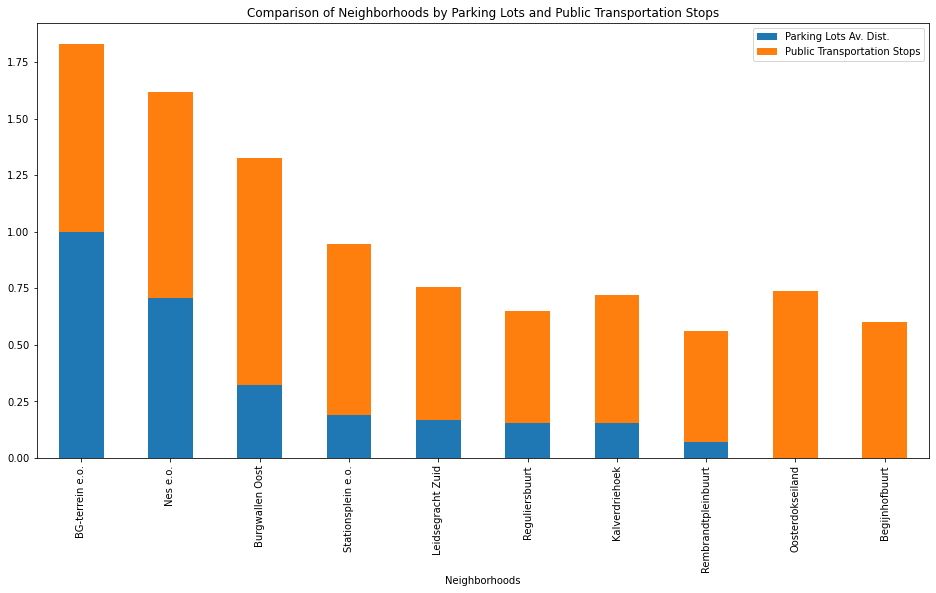

In [187]:
df_comparison.plot.bar(x="Neighborhood", y=["CarPark_Dist_N", "PubTrans_dis_N"],stacked=True,figsize=(16,8))
plt.xlabel('Neighborhoods') # x-label to the plot
plt.title('Comparison of Neighborhoods by Parking Lots and Public Transportation Stops') # title to the plot
plt.legend(('Parking Lots Av. Dist.', 'Public Transportation Stops'),loc=1) #legend of the plot
plt.show()

**Lets take the result from the comparison dataframe and establish the best neighborhood and save the final result in a new dataframe called result**

In [188]:
df_comparison['Total']=df_comparison['CarPark_Dist_N']+df_comparison['PubTrans_dis_N'] #create a new column
df_result=(df_comparison[df_comparison['Total'] == df_comparison['Total'].max()]).reset_index(drop=True) #return the max value and create a 
df_result

,Neighborhood,City,Latitude,Longitude,CarPark_dis,PubTrans_dis,CarPark_Dist_N,PubTrans_dis_N,Total
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1459.94,54,1.0,0.830769,1.830769


In [190]:
print('The best neighborhood for a new NightClub in Amsterdam is : {}'.format(df_result.at[0,'Neighborhood']))

The best neighborhood for a new NightClub in Amsterdam is : BG-terrein e.o.


In [191]:
n=0
m=0
for m in range(df_park['name'].count()):
    location1=list(df_result.loc[0,'Latitude':'Longitude'])
    location2=list(df_park.loc[m,'lat':'lng'])
    dist=float('%.2f' % geodesic(location1,location2).m)
    #dist_list.append(dist)
    if dist<500:
        n+=1
        print('Between {} and {} is {} meters'.format((df_result.loc[0,'Neighborhood']),(df_park.at[m,'name']),dist))
    else:
        continue
print('There are {} parking lots exist in {} below 500 meters distance'.format(n,df_result.at[0,'Neighborhood']))

Between BG-terrein e.o. and MobyPark - Parking Dam Square - Book now and pay only € 3/h! is 392.96 meters
Between BG-terrein e.o. and Parkeergarage Geelvinck is 429.25 meters
Between BG-terrein e.o. and ParkBee is 166.59 meters
Between BG-terrein e.o. and ParkBee Grand Hotel Krasnapolsky is 384.88 meters
Between BG-terrein e.o. and Parking wijdesteeg is 457.57 meters
Between BG-terrein e.o. and ParkBee Kalverstraat is 406.77 meters
Between BG-terrein e.o. and De Overkant (van MdB) is 210.57 meters
Between BG-terrein e.o. and ParkBee Hotel NH City Centre Amsterdam is 455.81 meters
Between BG-terrein e.o. and Amstel is 303.19 meters
Between BG-terrein e.o. and Parkeergarage Stadhuis-Muziektheater is 398.65 meters
Between BG-terrein e.o. and Q-park Kalverpassage is 387.52 meters
Between BG-terrein e.o. and Fietsenstallingen Singel is 435.3 meters
Between BG-terrein e.o. and Parkking The Bank Rembrandtplein is 403.97 meters
Between BG-terrein e.o. and Dam is 425.3 meters
Between BG-terrein

**Lets plot the results on a map highlighting the best neighborhood in red, the parking lots in blue, and the public transportation spots in orange**

In [192]:
result_latitude=df_result.at[0,'Latitude']
result_longitude=df_result.at[0,'Longitude']
result_name=df_result.at[0,'Neighborhood']

result_map = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=14) # generate map centred around Ecco


# show neighborhood as a red circle mark
folium.features.CircleMarker(
    [result_latitude, result_longitude],
    radius=10,
    popup=result_name,
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(result_map)


# add Parking Lots to the map as blue circle markers
for lat, lng, label in zip(df_park.lat, df_park.lng, df_park.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(result_map)
    

# add Light Rail/Metro/Train/Tram/Bus Station to the map as orange circle markers
for lat, lng, label in zip(df_trans_tot.lat, df_trans_tot.lng, df_trans_tot.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='orange',
        fill_color='orange',
        fill_opacity=0.6
        ).add_to(result_map)

# display map
result_map

### Results
**Therefore, the best location, based on the 17 parking lots within a less than 500m radius and the close vicinity to 54 public transportation stops within a 1000m radius, BG-terrein e.o. would be an optimal location to host a NightClub.** 